In [1]:
import IJulia
import Base64

# The julia kernel has built in support for Revise.jl, so this is the 
# recommended approach for long-running sessions:
# https://github.com/JuliaLang/IJulia.jl/blob/9b10fa9b879574bbf720f5285029e07758e50a5e/src/kernel.jl#L46-L51

# Users should enable revise within .julia/config/startup_ijulia.jl:
# https://timholy.github.io/Revise.jl/stable/config/#Using-Revise-automatically-within-Jupyter/IJulia-1

# clear console history
IJulia.clear_history()

fig_width = 10
fig_height = 5
fig_format = :retina
fig_dpi = 96

# no retina format type, use svg for high quality type/marks
if fig_format == :retina
  fig_format = :svg
elseif fig_format == :pdf
  fig_dpi = 96
  # Enable PDF support for IJulia
  IJulia.register_mime(MIME("application/pdf"))
end

# convert inches to pixels
fig_width = fig_width * fig_dpi
fig_height = fig_height * fig_dpi

# Intialize Plots w/ default fig width/height
try
  import Plots

  # Plots.jl doesn't support PDF output for versions < 1.28.1
  # so use png (if the DPI remains the default of 300 then set to 96)
  if (Plots._current_plots_version < v"1.28.1") & (fig_format == :pdf)
    Plots.gr(size=(fig_width, fig_height), fmt = :png, dpi = fig_dpi)
  else
    Plots.gr(size=(fig_width, fig_height), fmt = fig_format, dpi = fig_dpi)
  end
catch e
  # @warn "Plots init" exception=(e, catch_backtrace())
end

# Initialize CairoMakie with default fig width/height
try
  import CairoMakie

  # CairoMakie's display() in PDF format opens an interactive window
  # instead of saving to the ipynb file, so we don't do that.
  # https://github.com/quarto-dev/quarto-cli/issues/7548
  if fig_format == :pdf
    CairoMakie.activate!(type = "png")
  else
    CairoMakie.activate!(type = string(fig_format))
  end
  CairoMakie.update_theme!(resolution=(fig_width, fig_height))
catch e
    # @warn "CairoMakie init" exception=(e, catch_backtrace())
end
  
# Set run_path if specified
try
  run_path = "L1VzZXJzL211bGxpbnNqL0Ryb3Bib3gvVGVhY2hpbmcvRUNPTjQ1MzgvbGVjdHVyZXM="
  if !isempty(run_path)
    run_path = String(Base64.base64decode(run_path))
    cd(run_path)
  end
catch e
  @warn "Run path init:" exception=(e, catch_backtrace())
end


# emulate old Pkg.installed beahvior, see
# https://discourse.julialang.org/t/how-to-use-pkg-dependencies-instead-of-pkg-installed/36416/9
import Pkg
function isinstalled(pkg::String)
  any(x -> x.name == pkg && x.is_direct_dep, values(Pkg.dependencies()))
end

# ojs_define
if isinstalled("JSON") && isinstalled("DataFrames")
  import JSON, DataFrames
  global function ojs_define(; kwargs...)
    convert(x) = x
    convert(x::DataFrames.AbstractDataFrame) = Tables.rows(x)
    content = Dict("contents" => [Dict("name" => k, "value" => convert(v)) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
elseif isinstalled("JSON")
  import JSON
  global function ojs_define(; kwargs...)
    content = Dict("contents" => [Dict("name" => k, "value" => v) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
else
  global function ojs_define(; kwargs...)
    @warn "JSON package not available. Please install the JSON.jl package to use ojs_define."
  end
end


# don't return kernel dependencies (b/c Revise should take care of dependencies)
nothing


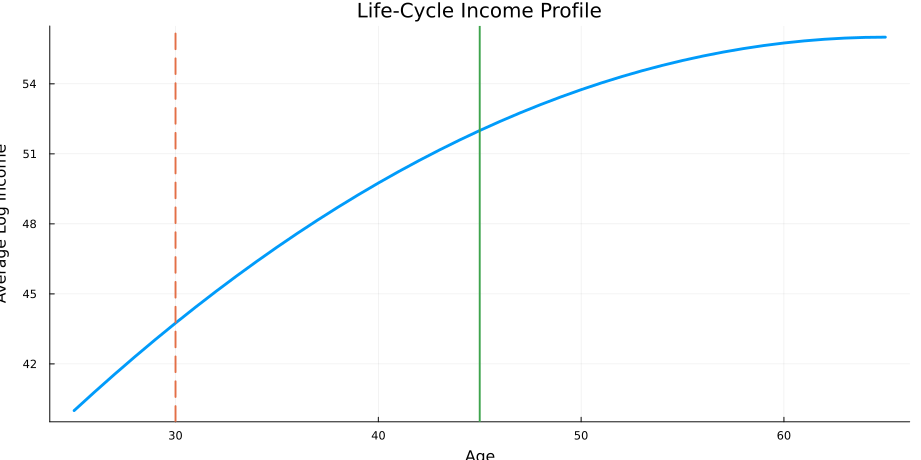

In [2]:
#| echo: false
#| output: true
using Plots, Random
ages = 25:65
# Stylized income profile (hump-shaped)
income_profile = 40 .+ 0.8 .* (ages .- 25) .- 0.01 .* (ages .- 25).^2

plot(ages, income_profile,
     linewidth=3,
     xlabel="Age",
     ylabel="Average Log Income",
     title="Life-Cycle Income Profile",
     legend=false,
     grid=true)
vline!([30], linestyle=:dash, linewidth=2, label="Too young")
vline!([45], linestyle=:solid, linewidth=2, label="Ideal")

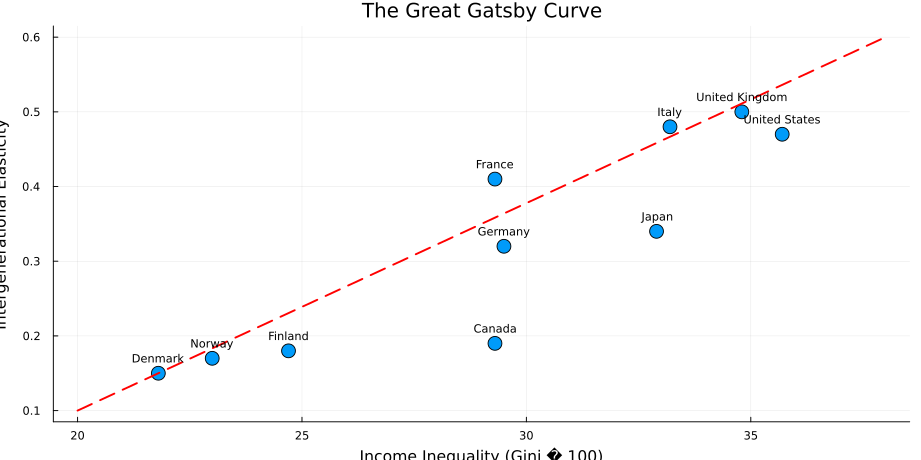

In [3]:
#| echo: false
#| output: true

# Data from Corak (2013)
countries = ["Denmark", "Norway", "Finland", "Canada", "Germany",
             "France", "Japan", "United States", "United Kingdom", "Italy"]
inequality = [21.8, 23.0, 24.7, 29.3, 29.5, 29.3, 32.9, 35.7, 34.8, 33.2]  # Gini
ige = [0.15, 0.17, 0.18, 0.19, 0.32, 0.41, 0.34, 0.47, 0.50, 0.48]

scatter(inequality, ige,
        markersize=8,
        xlabel="Income Inequality (Gini � 100)",
        ylabel="Intergenerational Elasticity",
        title="The Great Gatsby Curve",
        legend=false,
        grid=true)

# Add country labels
for i in 1:length(countries)
    annotate!(inequality[i], ige[i] + 0.02,
              text(countries[i], 8, :center))
end

# Add trend line (approximate)
plot!([20, 38], [0.1, 0.6],
      linestyle=:dash,
      color=:red,
      linewidth=2)

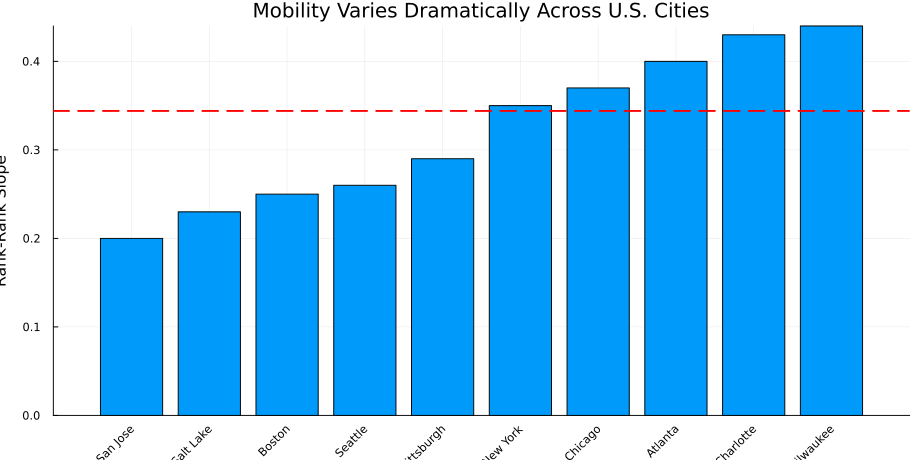

In [4]:
#| echo: false
#| output: true

# Stylized data based on Chetty et al. findings
# Showing rank-rank slopes by selected metros

metros = ["San Jose", "Salt Lake", "Boston", "Seattle", "Pittsburgh",
          "New York", "Chicago", "Atlanta", "Charlotte", "Milwaukee"]
rank_rank = [0.20, 0.23, 0.25, 0.26, 0.29, 0.35, 0.37, 0.40, 0.43, 0.44]

plot(1:length(metros), rank_rank,
     seriestype=:bar,
     xlabel="",
     ylabel="Rank-Rank Slope",
     title="Mobility Varies Dramatically Across U.S. Cities",
     legend=false,
     xticks=(1:length(metros), metros),
     xrotation=45,
     grid=true)
hline!([0.344], linestyle=:dash, linewidth=2, color=:red, label="National average")

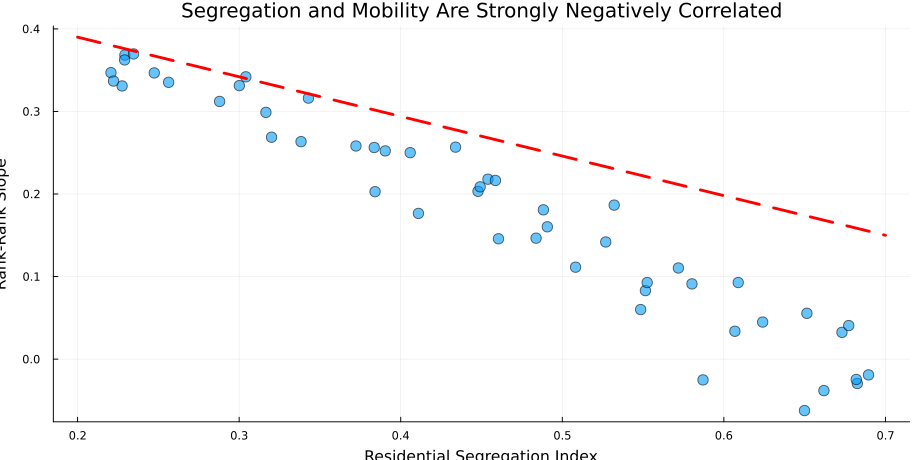

In [5]:
#| echo: false
#| output: true

# Stylized relationship between segregation and mobility
Random.seed!(456)
n_cities = 50
segregation = rand(n_cities) .* 0.5 .+ 0.2
mobility = 0.55 .- 0.8 .* segregation .+ randn(n_cities) .* 0.03

scatter(segregation, mobility,
        markersize=6,
        alpha=0.6,
        xlabel="Residential Segregation Index",
        ylabel="Rank-Rank Slope",
        title="Segregation and Mobility Are Strongly Negatively Correlated",
        legend=false,
        grid=true)

# Add trend
x_line = [0.2, 0.7]
y_line = [0.39, 0.15]
plot!(x_line, y_line,
      linewidth=3,
      color=:red,
      linestyle=:dash)

annotate!(0.35, 0.5, text("More segregation �\nLess mobility", 10, :left))

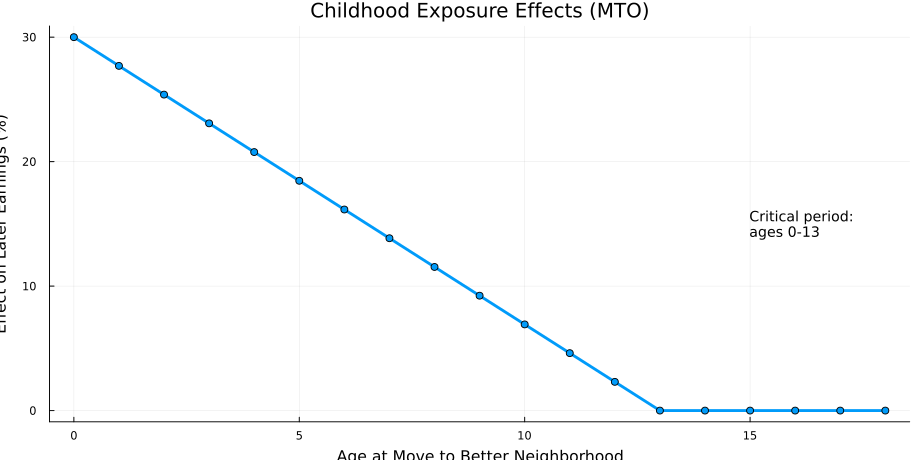

In [6]:
#| echo: false
#| output: true

# Stylized age-at-move effects from Chetty MTO reanalysis
ages = 0:18
# Effect declines linearly from age 0 to 13, then flat
effects = max.(0, 1 .- (ages ./ 13))

plot(ages, effects .* 30,
     linewidth=3,
     xlabel="Age at Move to Better Neighborhood",
     ylabel="Effect on Later Earnings (%)",
     title="Childhood Exposure Effects (MTO)",
     legend=false,
     grid=true,
     marker=:circle,
     markersize=4)
annotate!(15, 15, text("Critical period:\nages 0-13", 10, :left))